# Boundstate code

In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=0, which="LM", return_eigenvectors=False
                )
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)

    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=0, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


# Our code starts here

## System Creation

In [2]:
import kwant
import tinyarray
import numpy as np

import matplotlib.pyplot as plt

a = 1 # angstroms

norbs = 4 # N_t = 4

lat = kwant.lattice.chain(a, norbs=4)

# 2-site

In [3]:
# super lead - S - N - super lead

def make_system_ex2(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=2):
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(0))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    syst[(lat(1))] = (mu-2.*t+V_N)*tau_z + B*sigma_z
    
    syst[(lat(0), lat(1))] = np.matmul(sp.linalg.expm(phi*1j*tau_z), t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x))
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

## 3-site

In [4]:
## Explicit S-N-S (equivalent to explicit S-N as evidenced by Ryan's code)

def make_system_ex3(mu=0.5,
                t=-1., B=1., delta=0.5, alpha_so=0.5, V_N=1.25, phi=0, L=3):
    lat = kwant.lattice.chain(norbs=4)
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))

    #### Define the scattering region. ####
    syst[(lat(0))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    syst[(lat(x) for x in range(1, L-1))] = (mu-2.*t+V_N)*tau_z + B*sigma_z
    syst[(lat(L-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    
    syst[(lat(0), lat(1))] = np.matmul(sp.linalg.expm(phi*1j*tau_z), t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x))
    syst[(lat(1), lat(2))] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-a])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead0[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)
    sym_right = kwant.TranslationalSymmetry([a])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  (mu-2.*t)*tau_z + B*sigma_z + delta*tau_x
    lead1[lat.neighbors()] = t*tau_z + alpha_so*1j*np.matmul(tau_z, sigma_x)

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

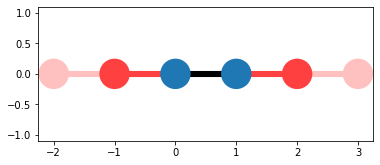

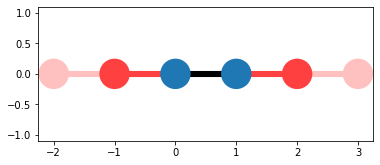

In [9]:
syst1 = make_system_ex2()
kwant.plot(syst1)

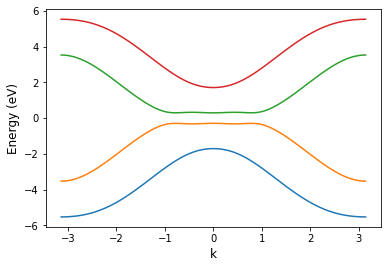

In [10]:
bands=kwant.physics.Bands(syst1.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
#plt.ylim(-2.,2)


plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

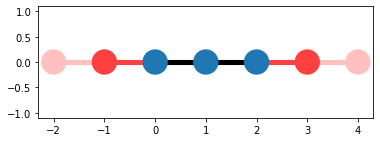

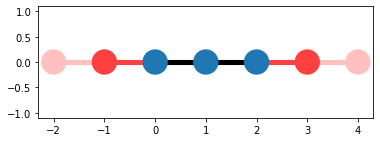

In [11]:
syst2 = make_system_ex3()
kwant.plot(syst2)

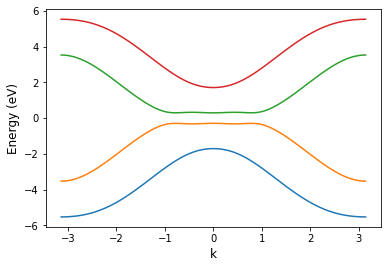

In [12]:
bands=kwant.physics.Bands(syst2.leads[1])
momenta=np.linspace(-np.pi,np.pi,101)
energies=[bands(k) for k in momenta]

x=np.array(energies)
en=(x)
#plt.ylim(-2.,2)


plt.plot(momenta, en)
plt.ylabel('Energy (eV)', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

## Replicating Fig. 9 (at t=0.7)

### 3 sites

In [23]:
def phi_scan_3(Bv=1., V_Nv=1.25, tv=-1.):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 2*np.pi, 21):
        syst = make_system_ex3(phi=i, B=Bv, V_N=V_Nv, t=tv)
        energies, wavefunctions = find_boundstates(syst, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [18]:
e_array1, psi_array1 = phi_scan(Bv=1., tv=0.7)
e_array2, psi_array2 = phi_scan(Bv=1., tv=0.7, V_Nv=2.5)
e_array3, psi_array3 = phi_scan(Bv=1., tv=0.7, V_Nv=5.)
print(e_array1)
print(e_array2)
print(e_array3)

[array([-0.26521014,  0.26521014]), array([-0.24199548,  0.24199548]), array([-0.19310138,  0.19310138]), array([-0.13319878,  0.13319878]), array([-0.06776965,  0.06776965]), array([1.73298875e-15, 1.73298875e-15]), array([-0.06776965,  0.06776965]), array([-0.13319878,  0.13319878]), array([-0.19310138,  0.19310138]), array([-0.24199548,  0.24199548]), array([-0.26521014,  0.26521014]), array([-0.24199548,  0.24199548]), array([-0.19310138,  0.19310138]), array([-0.13319878,  0.13319878]), array([-0.06776965,  0.06776965]), array([1.74513182e-15, 1.74513182e-15]), array([-0.06776965,  0.06776965]), array([-0.13319878,  0.13319878]), array([-0.19310138,  0.19310138]), array([-0.24199548,  0.24199548]), array([-0.26521014,  0.26521014])]
[array([-0.17236363,  0.17236363]), array([-0.16335258,  0.16335258]), array([-0.13774887,  0.13774887]), array([-0.09908471,  0.09908471]), array([-0.05169892,  0.05169892]), array([-8.67361738e-17, -8.67361738e-17]), array([-0.05169892,  0.05169892])

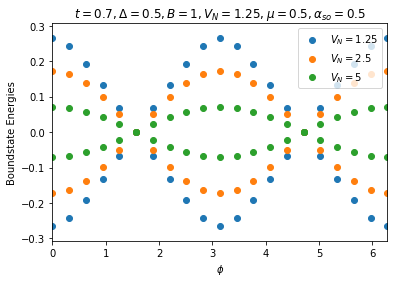

In [19]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array1)):
    for j in range(len(e_array1[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array1[i][j])
    for j in range(len(e_array2[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array2[i][j])
    for j in range(len(e_array3[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array3[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=0.7, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

In [20]:
e_array4, psi_array4 = phi_scan(Bv=0.4, tv=0.7)
e_array5, psi_array5 = phi_scan(Bv=0.4, tv=0.7, V_Nv=2.5)
e_array6, psi_array6 = phi_scan(Bv=0.4, tv=0.7, V_Nv=5.)
print(e_array4)
print(e_array5)
print(e_array6)

[array([-0.1935172,  0.1935172]), array([-0.18031305,  0.18031305]), array([-0.14555914,  0.14555914]), array([-0.10162621,  0.10162621]), array([-0.06431671,  0.06431671]), array([-0.04937898,  0.04937898]), array([-0.06431671,  0.06431671]), array([-0.10162621,  0.10162621]), array([-0.14555914,  0.14555914]), array([-0.18031305,  0.18031305]), array([-0.1935172,  0.1935172]), array([-0.18031305,  0.18031305]), array([-0.14555914,  0.14555914]), array([-0.10162621,  0.10162621]), array([-0.06431671,  0.06431671]), array([-0.04937898,  0.04937898]), array([-0.06431671,  0.06431671]), array([-0.10162621,  0.10162621]), array([-0.14555914,  0.14555914]), array([-0.18031305,  0.18031305]), array([-0.1935172,  0.1935172])]
[array([-0.24985597,  0.24985597]), array([-0.24580778,  0.24580778]), array([-0.2346202,  0.2346202]), array([-0.21988451,  0.21988451]), array([-0.20742178,  0.20742178]), array([-0.20255682,  0.20255682]), array([-0.20742178,  0.20742178]), array([-0.21988451,  0.219

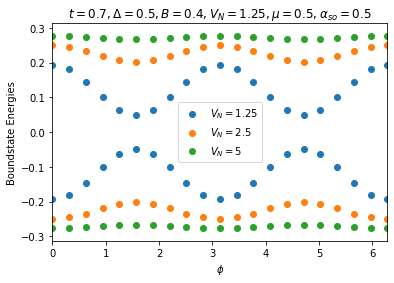

In [21]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array4)):
    for j in range(len(e_array4[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array4[i][j])
    for j in range(len(e_array5[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array5[i][j])
    for j in range(len(e_array6[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array6[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=0.7, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

### 2 sites (the spacings of spectra for diff onsite energies seem off compared to fig 9. Also we have extra modes at half-pi points (what should have been pi points if we use the conventioanl phase on delta implementation instead of phase on interface hopping) for trivial regime)

In [24]:
def phi_scan_2(Bv=1., V_Nv=1.25, tv=-1.):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 2*np.pi, 21):
        syst = make_system_ex2(phi=i, B=Bv, V_N=V_Nv, t=tv)
        energies, wavefunctions = find_boundstates(syst, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [26]:
e_array7, psi_array7 = phi_scan_2(Bv=1., tv=0.7)
e_array8, psi_array8 = phi_scan_2(Bv=1., tv=0.7, V_Nv=2.5)
e_array9, psi_array9 = phi_scan_2(Bv=1., tv=0.7, V_Nv=5.)
print(e_array7)
print(e_array8)
print(e_array9)

[array([-0.1705078,  0.1705078]), array([-0.1563339,  0.1563339]), array([-0.12324761,  0.12324761]), array([-0.08323489,  0.08323489]), array([-0.04163743,  0.04163743]), array([1.56125113e-17, 1.56125113e-17]), array([-0.04163743,  0.04163743]), array([-0.08323489,  0.08323489]), array([-0.12324761,  0.12324761]), array([-0.1563339,  0.1563339]), array([-0.1705078,  0.1705078]), array([-0.1563339,  0.1563339]), array([-0.12324761,  0.12324761]), array([-0.08323489,  0.08323489]), array([-0.04163743,  0.04163743]), array([1.6479873e-17, 1.6479873e-17]), array([-0.04163743,  0.04163743]), array([-0.08323489,  0.08323489]), array([-0.12324761,  0.12324761]), array([-0.1563339,  0.1563339]), array([-0.1705078,  0.1705078])]
[array([-0.15137985,  0.15137985]), array([-0.14182449,  0.14182449]), array([-0.11643303,  0.11643303]), array([-0.08141714,  0.08141714]), array([-0.04163604,  0.04163604]), array([-1.51788304e-16, -1.51788304e-16]), array([-0.04163604,  0.04163604]), array([-0.0814

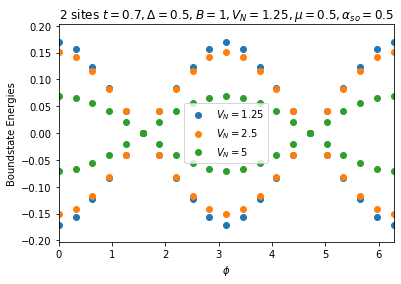

In [29]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array7)):
    for j in range(len(e_array7[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array7[i][j])
    for j in range(len(e_array8[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array8[i][j])
    for j in range(len(e_array9[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array9[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $t=0.7, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

In [28]:
e_array10, psi_array10 = phi_scan_2(Bv=0.4, tv=0.7)
e_array11, psi_array11 = phi_scan_2(Bv=0.4, tv=0.7, V_Nv=2.5)
e_array12, psi_array12 = phi_scan_2(Bv=0.4, tv=0.7, V_Nv=5.)
print(e_array10)
print(e_array11)
print(e_array12)

[array([-0.24308993,  0.24308993]), array([-0.22638088,  0.22638088]), array([-0.18543618,  0.18543618]), array([-0.13595604,  0.13595604]), array([-0.09472286,  0.09472286]), array([-0.28377016, -0.07828945,  0.07828945,  0.28377016]), array([-0.09472286,  0.09472286]), array([-0.13595604,  0.13595604]), array([-0.18543618,  0.18543618]), array([-0.22638088,  0.22638088]), array([-0.24308993,  0.24308993]), array([-0.22638088,  0.22638088]), array([-0.18543618,  0.18543618]), array([-0.13595604,  0.13595604]), array([-0.09472286,  0.09472286]), array([-0.28377016, -0.07828945,  0.07828945,  0.28377016]), array([-0.09472286,  0.09472286]), array([-0.13595604,  0.13595604]), array([-0.18543618,  0.18543618]), array([-0.22638088,  0.22638088]), array([-0.24308993,  0.24308993])]
[array([-0.27712146,  0.27712146]), array([-0.2689044,  0.2689044]), array([-0.25142299,  0.25142299]), array([-0.23212189,  0.23212189]), array([-0.21715817,  0.21715817]), array([-0.21151747,  0.21151747]), arr

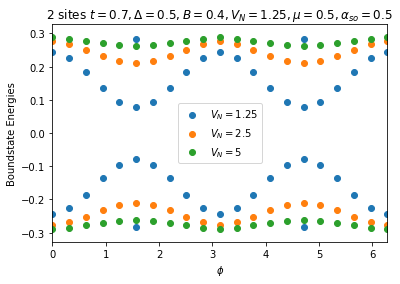

In [30]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array10)):
    for j in range(len(e_array10[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array10[i][j])
    for j in range(len(e_array11[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array11[i][j])
    for j in range(len(e_array12[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array12[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $t=0.7, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

## Unphysical solutions we got at other parameters

### 3 sites

In [32]:
e_array1t, psi_array1t = phi_scan_3(Bv=1., tv=-1.)
e_array2t, psi_array2t = phi_scan_3(Bv=1., tv=-1., V_Nv=2.5)
e_array3t, psi_array3t = phi_scan_3(Bv=1., tv=-1., V_Nv=5.)
print(e_array1t)
print(e_array2t)
print(e_array3t)

[array([-0.27053993, -0.09671577,  0.09671577,  0.27053993]), array([-0.27498478, -0.0906275 ,  0.0906275 ,  0.27498478]), array([-0.28550755, -0.07445547,  0.07445547,  0.28550755]), array([-0.05212824,  0.05212824]), array([-0.02668997,  0.02668997]), array([-8.11850587e-16, -8.11850587e-16]), array([-0.02668997,  0.02668997]), array([-0.05212824,  0.05212824]), array([-0.28550755, -0.07445547,  0.07445547,  0.28550755]), array([-0.27498478, -0.0906275 ,  0.0906275 ,  0.27498478]), array([-0.27053993, -0.09671577,  0.09671577,  0.27053993]), array([-0.27498478, -0.0906275 ,  0.0906275 ,  0.27498478]), array([-0.28550755, -0.07445547,  0.07445547,  0.28550755]), array([-0.05212824,  0.05212824]), array([-0.02668997,  0.02668997]), array([-8.00574884e-16, -8.00574884e-16]), array([-0.02668997,  0.02668997]), array([-0.05212824,  0.05212824]), array([-0.28550755, -0.07445547,  0.07445547,  0.28550755]), array([-0.27498478, -0.0906275 ,  0.0906275 ,  0.27498478]), array([-0.27053993, -0.

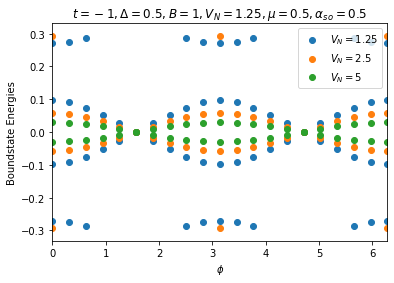

In [33]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array1t)):
    for j in range(len(e_array1t[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array1t[i][j])
    for j in range(len(e_array2t[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array2t[i][j])
    for j in range(len(e_array3t[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array3t[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=-1, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

In [34]:
e_array4t, psi_array4t = phi_scan_3(Bv=0.4, tv=-1.)
e_array5t, psi_array5t = phi_scan_3(Bv=0.4, tv=-1., V_Nv=2.5)
e_array6t, psi_array6t = phi_scan_3(Bv=0.4, tv=-1., V_Nv=5.)
print(e_array4t)
print(e_array5t)
print(e_array6t)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.30709689,  0.30709689]), array([-0.30703901,  0.30703901]), array([-0.30709689,  0.30709689]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.30709689,  0.30709689]), array([-0.30703901,  0.30703901]), array([-0.30709689,  0.30709689]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([]

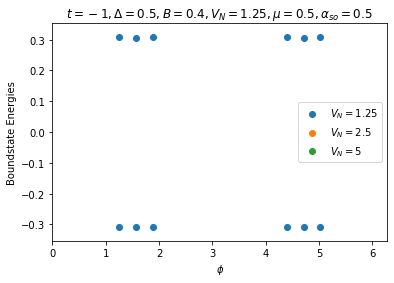

In [35]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array4t)):
    for j in range(len(e_array4t[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array4t[i][j])
    for j in range(len(e_array5t[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array5t[i][j])
    for j in range(len(e_array6t[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array6t[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'$t=-1, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

### 2 sites

In [36]:
e_array7t, psi_array7t = phi_scan_2(Bv=1., tv=-1.)
e_array8t, psi_array8t = phi_scan_2(Bv=1., tv=-1., V_Nv=2.5)
e_array9t, psi_array9t = phi_scan_2(Bv=1., tv=-1., V_Nv=5.)
print(e_array7t)
print(e_array8t)
print(e_array9t)

[array([-0.28745671, -0.15288878,  0.15288878,  0.28745671]), array([-0.29086474, -0.14291951,  0.14291951,  0.29086474]), array([-0.11709969,  0.11709969]), array([-0.08200606,  0.08200606]), array([-0.0420533,  0.0420533]), array([1.5959456e-16, 1.5959456e-16]), array([-0.0420533,  0.0420533]), array([-0.08200606,  0.08200606]), array([-0.11709969,  0.11709969]), array([-0.29086474, -0.14291951,  0.14291951,  0.29086474]), array([-0.28745671, -0.15288878,  0.15288878,  0.28745671]), array([-0.29086474, -0.14291951,  0.14291951,  0.29086474]), array([-0.11709969,  0.11709969]), array([-0.08200606,  0.08200606]), array([-0.0420533,  0.0420533]), array([-1.20910226e-15, -1.20910226e-15]), array([-0.0420533,  0.0420533]), array([-0.08200606,  0.08200606]), array([-0.11709969,  0.11709969]), array([-0.29086474, -0.14291951,  0.14291951,  0.29086474]), array([-0.28745671, -0.15288878,  0.15288878,  0.28745671])]
[array([-0.09406351,  0.09406351]), array([-0.0891076,  0.0891076]), array([-0

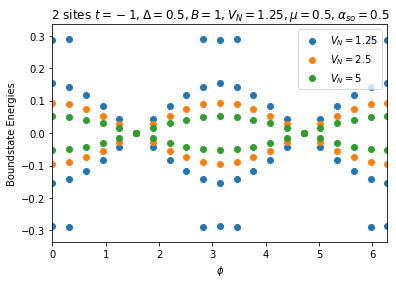

In [37]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array7t)):
    for j in range(len(e_array7t[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array7t[i][j])
    for j in range(len(e_array8t[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array8t[i][j])
    for j in range(len(e_array9t[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array9t[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $t=-1, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

In [38]:
e_array10t, psi_array10t = phi_scan_2(Bv=0.4, tv=-1.)
e_array11t, psi_array11t = phi_scan_2(Bv=0.4, tv=-1., V_Nv=2.5)
e_array12t, psi_array12t = phi_scan_2(Bv=0.4, tv=-1., V_Nv=5.)
print(e_array10t)
print(e_array11t)
print(e_array12t)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], 

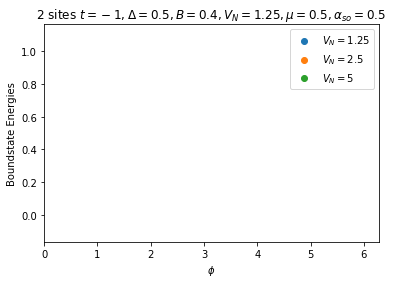

In [39]:
ex = []
ey = []
ex1 = []
ey1 = []
ex2 = []
ey2 = []
for i in range(len(e_array10t)):
    for j in range(len(e_array10t[i])):
        ex.append(i/10.*np.pi)
        ey.append(e_array10t[i][j])
    for j in range(len(e_array11t[i])):
        ex1.append(i/10.*np.pi)
        ey1.append(e_array11t[i][j])
    for j in range(len(e_array12t[i])):
        ex2.append(i/10.*np.pi)
        ey2.append(e_array12t[i][j])
plt.scatter(ex, ey, label=r'$V_N=1.25$')
plt.scatter(ex1, ey1, label=r'$V_N=2.5$')
plt.scatter(ex2, ey2, label=r'$V_N=5$')
plt.xlim(0, 2*np.pi)
plt.xlabel(r'$\phi$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $t=-1, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')
plt.legend()

## B scan

### 3 sites

In [42]:
def B_scan_3(phiv=0., V_Nv=1.25, tv=-1):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 1, 21):
        syst = make_system_ex3(phi=phiv, B=i, V_N=V_Nv, t=tv)
        energies, wavefunctions = find_boundstates(syst, -0.8, 0.8, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [43]:
Be_array1, Bpsi_array1 = B_scan_3()
print(Be_array1)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.53260317,  0.53260317]), array([-0.49729178,  0.49729178]), array([-0.45414739,  0.45414739]), array([-0.40682885,  0.40682885]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.02484905,  0.02484905]), array([-0.04748073,  0.04748073]), array([-0.06481062,  0.06481062]), array([-0.07817022,  0.07817022]), array([-0.24270832, -0.08856201,  0.08856201,  0.24270832]), array([-0.27053993, -0.09671577,  0.09671577,  0.27053993])]


Text(0.5, 1.0, '3 sites $\\phi=0, \\Delta=0.5, t=-1$')

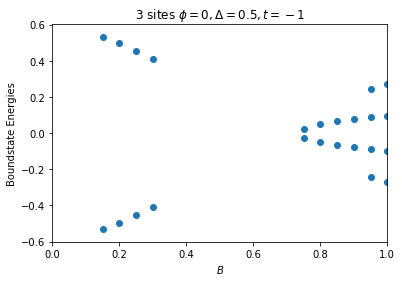

In [44]:
Bex = []
Bey = []
for i in range(len(Be_array1)):
    for j in range(len(Be_array1[i])):
        Bex.append(i/20.)
        Bey.append(Be_array1[i][j])
plt.scatter(Bex, Bey)
plt.xlim(0, 1)
plt.xlabel(r'$B$')
plt.ylabel('Boundstate Energies')
plt.title(r'3 sites $\phi=0, \Delta=0.5, t=-1$')

In [45]:
Be_array2, Bpsi_array2 = B_scan_3(tv=0.7)
print(Be_array2)

[array([-0.45867705, -0.45867705,  0.45867705,  0.45867705]), array([-0.47615944, -0.43424022,  0.43424022,  0.47615944]), array([-0.40501913,  0.40501913]), array([-0.37262109,  0.37262109]), array([-0.33818823,  0.33818823]), array([-0.30253007,  0.30253007]), array([-0.26623881,  0.26623881]), array([-0.22977313,  0.22977313]), array([-0.1935172,  0.1935172]), array([-0.15782441,  0.15782441]), array([-0.12305473,  0.12305473]), array([-0.08961404,  0.08961404]), array([-0.05800519,  0.05800519]), array([-0.02890482,  0.02890482]), array([0.00328348]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.26521014,  0.26521014])]


Text(0.5, 1.0, '3 sites $\\phi=0, \\Delta=0.5, t=0.7$')

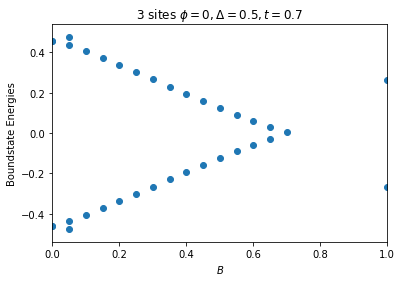

In [46]:
Bex = []
Bey = []
for i in range(len(Be_array2)):
    for j in range(len(Be_array2[i])):
        Bex.append(i/20.)
        Bey.append(Be_array2[i][j])
plt.scatter(Bex, Bey)
plt.xlim(0, 1)
plt.xlabel(r'$B$')
plt.ylabel('Boundstate Energies')
plt.title(r'3 sites $\phi=0, \Delta=0.5, t=0.7$')

In [52]:
def spectral_gap_scan3(tv=-1.):
    band_gap_array = []
    for i in np.linspace(0., 1, 1001):
        syst = make_system_ex3(B=i, phi=0.*np.pi, t=tv)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,101)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
    return band_gap_array

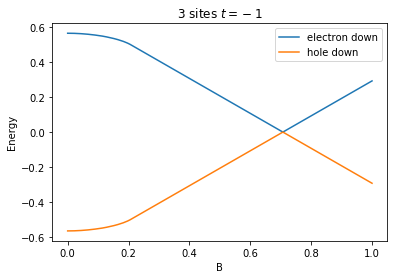

In [51]:
band_gap_array = np.array(spectral_gap_scan3())

plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,1], label='hole down')
plt.xlabel('B')
plt.ylabel('Energy')
plt.title(r'3 sites $t=-1$')
plt.legend()

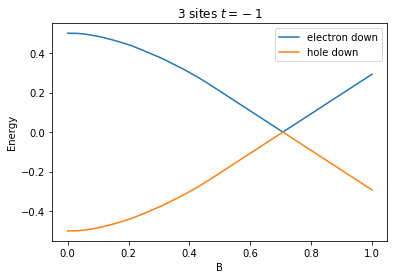

In [53]:
band_gap_array = np.array(spectral_gap_scan3(tv=0.7))

plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,1], label='hole down')
plt.xlabel('B')
plt.ylabel('Energy')
plt.title(r'3 sites $t=-1$')
plt.legend()

### 2 sites

In [54]:
def B_scan_2(phiv=0., V_Nv=1.25, tv=-1):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(0, 1, 21):
        syst = make_system_ex2(phi=phiv, B=i, V_N=V_Nv, t=tv)
        energies, wavefunctions = find_boundstates(syst, -0.8, 0.8, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [55]:
Be_array3, Bpsi_array3 = B_scan_2()
print(Be_array3)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.03416887,  0.03416887]), array([-0.0690673,  0.0690673]), array([-0.09808039,  0.09808039]), array([-0.12126352,  0.12126352]), array([-0.13923762,  0.13923762]), array([-0.28745671, -0.15288878,  0.15288878,  0.28745671])]


Text(0.5, 1.0, '2 sites $\\phi=0, \\Delta=0.5, t=-1$')

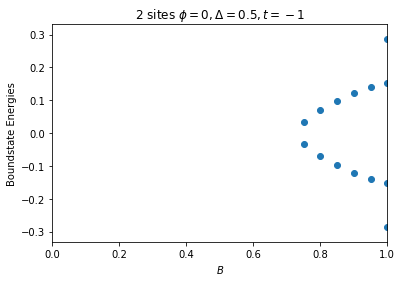

In [56]:
Bex = []
Bey = []
for i in range(len(Be_array3)):
    for j in range(len(Be_array3[i])):
        Bex.append(i/20.)
        Bey.append(Be_array3[i][j])
plt.scatter(Bex, Bey)
plt.xlim(0, 1)
plt.xlabel(r'$B$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $\phi=0, \Delta=0.5, t=-1$')

In [57]:
Be_array4, Bpsi_array4 = B_scan_2(tv=0.7)
print(Be_array4)

[array([-0.45867705, -0.45867705,  0.45867705,  0.45867705]), array([-0.4641663 , -0.44628737,  0.44628737,  0.4641663 ]), array([-0.45936528, -0.42836049,  0.42836049,  0.45936528]), array([-0.44307681, -0.40553799,  0.40553799,  0.44307681]), array([-0.41984205, -0.37846705,  0.37846705,  0.41984205]), array([-0.39289799, -0.34793269,  0.34793269,  0.39289799]), array([-0.36338433, -0.31475018,  0.31475018,  0.36338433]), array([-0.27962486,  0.27962486]), array([-0.24308993,  0.24308993]), array([-0.20551234,  0.20551234]), array([-0.16712114,  0.16712114]), array([-0.12803121,  0.12803121]), array([-0.0882522,  0.0882522]), array([-0.04767674,  0.04767674]), array([-0.00603306,  0.00603306]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.18131339,  0.18131339]), array([-0.18011339,  0.18011339]), array([-0.1705078,  0.1705078])]


Text(0.5, 1.0, '2 sites $\\phi=0, \\Delta=0.5, t=0.7$')

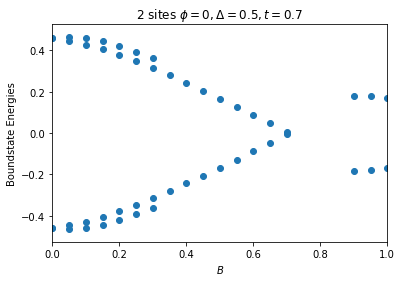

In [58]:
Bex = []
Bey = []
for i in range(len(Be_array4)):
    for j in range(len(Be_array4[i])):
        Bex.append(i/20.)
        Bey.append(Be_array4[i][j])
plt.scatter(Bex, Bey)
plt.xlim(0, 1)
plt.xlabel(r'$B$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $\phi=0, \Delta=0.5, t=0.7$')

In [59]:
def spectral_gap_scan2(tv=-1.):
    band_gap_array = []
    for i in np.linspace(0., 1, 1001):
        syst = make_system_ex2(B=i, phi=0.*np.pi, t=tv)
        bands=kwant.physics.Bands(syst.leads[1])
        momenta=np.linspace(-np.pi,np.pi,101)
        energies=[bands(k) for k in momenta]
        x=np.array(energies)
        en=(x)
        band_gap_array.append([np.min(en[:,2]), np.max(en[:,1])])
    return band_gap_array

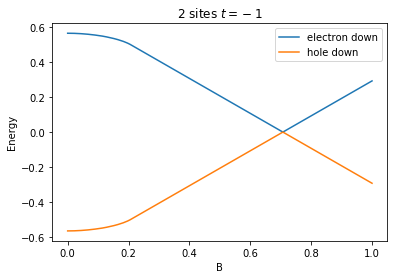

In [60]:
band_gap_array = np.array(spectral_gap_scan2())

plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,1], label='hole down')
plt.xlabel('B')
plt.ylabel('Energy')
plt.title(r'2 sites $t=-1$')
plt.legend()

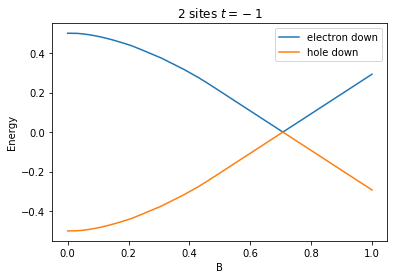

In [61]:
band_gap_array = np.array(spectral_gap_scan2(tv=0.7))

plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,0], label='electron down')
plt.plot(np.linspace(0., 1, 1001), band_gap_array[:,1], label='hole down')
plt.xlabel('B')
plt.ylabel('Energy')
plt.title(r'2 sites $t=-1$')
plt.legend()

## t scan

### We did this originally to uncover possible values of t at which we could replicate fig. 9. The behaviour of the t scans depend strongly on how we partition between scattering region and leads, it seems.

In [70]:
def t_scan3(phiv=0., V_Nv=1.25, Bv=1.):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(-1, 1, 21):
        syst = make_system_ex3(phi=phiv, B=Bv, V_N=V_Nv, t=i)
        energies, wavefunctions = find_boundstates(syst, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [71]:
te_array1, tpsi_array1 = t_scan3()
print(te_array1)

[array([-0.27053993, -0.09671577,  0.09671577,  0.27053993]), array([-0.27785232, -0.08626887,  0.08626887,  0.27785232]), array([-0.28480819, -0.07258018,  0.07258018,  0.28480819]), array([-0.29054037, -0.0546623 ,  0.0546623 ,  0.29054037]), array([-0.03144084,  0.03144084]), array([0.00223441]), array([-0.03175986,  0.03175986]), array([-0.06337857,  0.06337857]), array([-0.06971637,  0.06971637]), array([-0.0083274,  0.0083274]), array([-0.24324112,  0.24324112]), array([-0.13322025,  0.13322025]), array([-0.02793662,  0.02793662]), array([-0.12473077,  0.12473077]), array([-0.14100651,  0.14100651]), array([-0.25845268,  0.25845268]), array([], dtype=float64), array([-0.26521014,  0.26521014]), array([-0.22326907,  0.22326907]), array([-0.18551432,  0.18551432]), array([-0.15536962,  0.15536962])]


Text(0.5, 1.0, '3 sites $\\phi=0.5\\pi, \\Delta=0.5, B=1, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

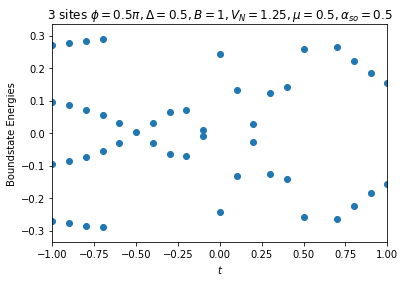

In [72]:
tex = []
tey = []
for i in range(len(te_array1)):
    for j in range(len(te_array1[i])):
        tex.append(i/10.-1.)
        tey.append(te_array1[i][j])
plt.scatter(tex, tey)
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'3 sites $\phi=0.5\pi, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')

In [73]:
te_array2, tpsi_array2 = t_scan3(Bv=0.4)
print(te_array2)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.30616475,  0.30616475]), array([-0.29242704,  0.29242704]), array([-0.26045424,  0.26045424]), array([], dtype=float64), array([], dtype=float64), array([-0.22934366,  0.22934366]), array([-0.20753284,  0.20753284]), array([-0.19705579,  0.19705579]), array([-0.19344136,  0.19344136]), array([-0.1935172,  0.1935172]), array([-0.19545077,  0.19545077]), array([-0.19821108,  0.19821108]), array([-0.20122843,  0.20122843])]


Text(0.5, 1.0, '3 sites $\\phi=0.5\\pi, \\Delta=0.5, B=0.4, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

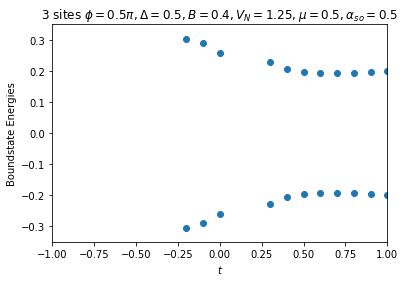

In [74]:
tex = []
tey = []
for i in range(len(te_array2)):
    for j in range(len(te_array2[i])):
        tex.append(i/10.-1.)
        tey.append(te_array2[i][j])
plt.scatter(tex, tey)
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'3 sites $\phi=0.5\pi, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')

In [75]:
def t_scan2(phiv=0., V_Nv=1.25, Bv=1.):
    energy_arrays = []
    wavefunc_arrays = []
    for i in np.linspace(-1, 1, 21):
        syst = make_system_ex2(phi=phiv, B=Bv, V_N=V_Nv, t=i)
        energies, wavefunctions = find_boundstates(syst, -0.6, 0.6, rtol=1e-2)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
    return energy_arrays, wavefunc_arrays

In [76]:
te_array3, tpsi_array3 = t_scan2()
print(te_array3)

[array([-0.28745671, -0.15288878,  0.15288878,  0.28745671]), array([-0.15167811,  0.15167811]), array([-0.14949419,  0.14949419]), array([-0.14584282,  0.14584282]), array([-0.13990736,  0.13990736]), array([-0.13029822,  0.13029822]), array([-0.11462288,  0.11462288]), array([-0.0889648,  0.0889648]), array([-0.04870094,  0.04870094]), array([0.00191676]), array([-0.24324112,  0.24324112]), array([-0.13532504,  0.13532504]), array([-0.01396219,  0.01396219]), array([-0.13556612,  0.13556612]), array([-0.0912632,  0.0912632]), array([-0.28445149, -0.15221127,  0.15221127,  0.28445149]), array([-0.17033642,  0.17033642]), array([-0.1705078,  0.1705078]), array([-0.15880109,  0.15880109]), array([-0.13738616,  0.13738616]), array([-0.29201676, -0.10886928,  0.10886928,  0.29201676])]


Text(0.5, 1.0, '2 sites $\\phi=0.5\\pi, \\Delta=0.5, B=1, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

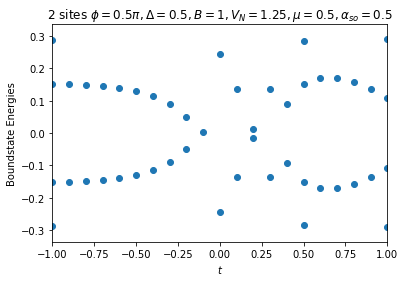

In [77]:
tex = []
tey = []
for i in range(len(te_array3)):
    for j in range(len(te_array3[i])):
        tex.append(i/10.-1.)
        tey.append(te_array3[i][j])
plt.scatter(tex, tey)
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $\phi=0.5\pi, \Delta=0.5, B=1, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')

In [78]:
te_array4, tpsi_array4 = t_scan2(Bv=0.4)
print(te_array4)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([-0.30697601,  0.30697601]), array([-0.30546042,  0.30546042]), array([-0.30222521,  0.30222521]), array([-0.29768387,  0.29768387]), array([-0.29073778,  0.29073778]), array([-0.26045424,  0.26045424]), array([], dtype=float64), array([-0.18281962,  0.18281962]), array([-0.28940757,  0.28940757]), array([-0.27047182,  0.27047182]), array([-0.25716137,  0.25716137]), array([-0.24830405,  0.24830405]), array([-0.24308993,  0.24308993]), array([-0.2403789,  0.2403789]), array([-0.23927486,  0.23927486]), array([-0.23914857,  0.23914857])]


Text(0.5, 1.0, '2 sites $\\phi=0.5\\pi, \\Delta=0.5, B=0.4, V_N=1.25, \\mu=0.5, \\alpha_{so}=0.5$')

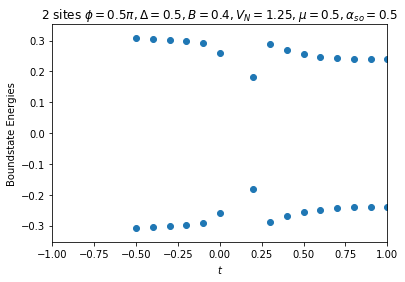

In [79]:
tex = []
tey = []
for i in range(len(te_array4)):
    for j in range(len(te_array4[i])):
        tex.append(i/10.-1.)
        tey.append(te_array4[i][j])
plt.scatter(tex, tey)
plt.xlim(-1, 1)
plt.xlabel(r'$t$')
plt.ylabel('Boundstate Energies')
plt.title(r'2 sites $\phi=0.5\pi, \Delta=0.5, B=0.4, V_N=1.25, \mu=0.5, \alpha_{so}=0.5$')